In [1]:
import pandas as pd
#Script merge de deux fichiers CSV
# Charger les deux fichiers
df_gpw = pd.read_csv('WHO_SDG_GPW_standardisé_avec_code_pays.csv')
df_sdg3 = pd.read_csv('WHO_SDG3_standardisé_avec_code_pays.csv')

# 1. Identifier les colonnes communes (Clés de fusion)
# On suppose ici que les colonnes identifiantes ont le même nom (ex: 'ParentLocation', 'Location', 'Period')
# Ajustez cette liste selon vos vrais noms de colonnes
keys = ['Pays_code_iso3'] 

# Vérification rapide si les clés existent dans les deux
missing_keys = [k for k in keys if k not in df_gpw.columns or k not in df_sdg3.columns]
if missing_keys:
    print(f"Attention : Les colonnes clés {missing_keys} ne sont pas présentes dans les deux fichiers.")
else:
    # 2. Fusionner intelligemment (Merge)
    # how='outer' garde toutes les données (même si un pays manque dans l'un des deux fichiers)
    # how='inner' ne garde que les lignes présentes dans les DEUX fichiers
    df_fusionne = pd.merge(df_gpw, df_sdg3, on=keys, how='outer', suffixes=('_gpw', '_sdg3'))

    print('=== Table fusionnée (Merge sécurisé) ===')
    print(f'Shape: {df_fusionne.shape}')
    
    # Vérifier s'il y a eu duplication de lignes indésirable
    if df_fusionne.shape[0] > max(df_gpw.shape[0], df_sdg3.shape[0]):
        print("Note: Le nombre de lignes a augmenté. Vérifiez les doublons dans les clés de jointure.")

    print(df_fusionne.head())

    # Sauvegarder
    df_fusionne.to_csv('WHO_SDG_GPW_SDG3_fusionne_secure.csv', index=False)
    print('\n✓ Table fusionnée sauvegardée.')

=== Table fusionnée (Merge sécurisé) ===
Shape: (197, 62)
  LOCATION_gpw Pays_code_iso3  Surpoids enfants <5 ans  \
0  Afghanistan            AFG                      4.4   
1      Albania            ALB                     16.7   
2      Algeria            DZA                     13.3   
3      Andorra            AND                      NaN   
4       Angola            AGO                      4.7   

   Dépenses publiques santé  Anémie femmes 15-49 ans  \
0                      1.13                     45.4   
1                      9.19                     24.7   
2                      5.36                     31.6   
3                     15.87                     16.4   
4                      6.70                     43.8   

   Concentration particules air PM2.5  Aide eau et assainissement  \
0                               75.19                        46.1   
1                               16.58                        43.7   
2                               22.85            

Régression de 'Espérance de vie totale' sur 'Dépenses publiques santé'
                               OLS Regression Results                              
Dep. Variable:     Espérance de vie totale   R-squared:                       0.363
Model:                                 OLS   Adj. R-squared:                  0.360
Method:                      Least Squares   F-statistic:                     102.1
Date:                     Sat, 06 Dec 2025   Prob (F-statistic):           2.82e-19
Time:                             11:59:15   Log-Likelihood:                -572.51
No. Observations:                      181   AIC:                             1149.
Df Residuals:                          179   BIC:                             1155.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.9

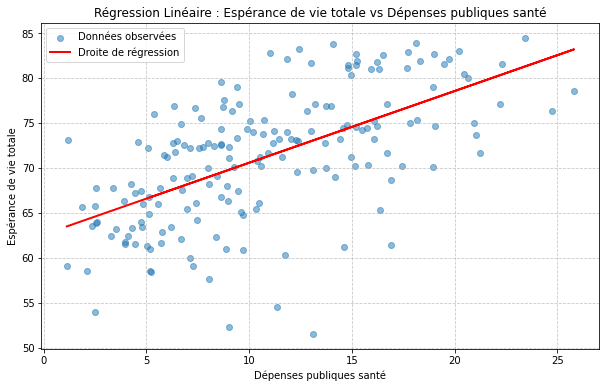

In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Charger les données (la table fusionnée)
file_path = 'WHO_SDG_GPW_SDG3_fusionne_secure.csv'  # ou votre fichier sécurisé
df = pd.read_csv(file_path)

# --- CONFIGURATION DES VARIABLES ---
# Remplacez ces noms par les colonnes exactes de votre fichier
colonne_Y = 'Espérance de vie totale'  # La variable à prédire (ex: Espérance de vie)
colonne_D = 'Dépenses publiques santé'  # La variable explicative (ex: PIB, Dépenses santé)

print(f"Régression de '{colonne_Y}' sur '{colonne_D}'")

# 2. Nettoyage des données
# La régression ne supporte pas les valeurs manquantes (NaN)
data_reg = df[[colonne_Y, colonne_D]].dropna()

# Vérification qu'il reste des données
if len(data_reg) == 0:
    print("Erreur : Plus aucune donnée après suppression des valeurs manquantes.")
else:
    # 3. Préparation des variables
    Y = data_reg[colonne_Y]
    D = data_reg[colonne_D]
    
    # AJOUT DE LA CONSTANTE (C'est votre "1" dans X=(1,D))
    # Sans cela, la droite passerait forcément par 0 (l'origine)
    X = sm.add_constant(D) 

    # 4. Ajustement du modèle (OLS = Ordinary Least Squares)
    model = sm.OLS(Y, X)
    results = model.fit()

    # 5. Afficher le rapport statistique complet
    print(results.summary())

    # --- VISUALISATION ---
    plt.figure(figsize=(10, 6))
    
    # Nuage de points (Données réelles)
    plt.scatter(data_reg[colonne_D], data_reg[colonne_Y], alpha=0.5, label='Données observées')
    
    # Droite de régression (Prédictions)
    # On utilise les paramètres du modèle pour tracer la ligne
    plt.plot(data_reg[colonne_D], results.predict(X), color='red', linewidth=2, label='Droite de régression')
    
    plt.title(f'Régression Linéaire : {colonne_Y} vs {colonne_D}')
    plt.xlabel(colonne_D)
    plt.ylabel(colonne_Y)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Sauvegarder le graphique
    plt.savefig('resultat_regression.png')
    print("\n✓ Graphique sauvegardé sous 'resultat_regression.png'")
    # plt.show() # Décommentez si vous exécutez cela dans un notebook Jupyter local